# **Домашнее задание 3. Линейная классификация (base)**

### **Оценивание и штрафы**

С наступающим новым годом, друзья! Магистратура бежит быстро и мы бежим очень быстро, а зима — то время, когда хотелось бы бежать чуть медленнее. Поэтому это домашнее задание мы сделали сильно короче от его начальной версии!

Как всегда, каждая из задач имеет «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

В задании две части:

- Часть 1: написание логистической регрессии своими руками — уверенны, логлосс вы уже знаете как свои пять пальцев.
- Часть 2: решение задачи классификации на текстах.

In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (5 баллов)**

Логистическая регрессия — безумно важная и удобная модель для понимания начальных концепций. Вы много практиковались с выведением формулы градиента логлосса, шага спуска, а в прошлом дз сделали SGD. Давайте сделаем ещё шаг вперед — и реализуем логистическую регрессию своими руками.

На практике, часто хватает алгоритмов из коробки. Но иногда очень удобно сделать свой алгоритм.

## **Теоретическая сноска: почему LogLoss'а так много**

Почти наверное (в математике это значит, во всех случаях, кроме множества размером 0) логлосс набил оскомину за несколько заданий. Давайте посмотрим на него ещё раз:

В логистической регрессии функция потерь

$$\text{LogLoss}(y, \hat{p}) = -\left(y\log \hat{p} + (1-y)\log (1-\hat{p})\right)$$

Зачем мы так долго с ней возимся?

#### **Пункт 1.**
Во-первых, это **следствие максимизации правдоподобия** при биномиальной модели.

Если считать, что целевая переменная (Y\in{0,1}) распределена как

$$P(Y=1 \mid x) = \hat{p}(x), \qquad P(Y=0\mid x) = 1-\hat{p}(x),$$
то правдоподобие выборки ( (x_i, y_i) )\ равно
$$L = \prod_{i=1}^n \hat{p}_i^{y_i}(1-\hat{p}_i)^{1-y_i}.$$

Максимизация $\log L$ эквивалентна минимизации LogLoss.
Таким образом, LogLoss — **единственная функция потерь, полностью согласованная с вероятностной моделью логистической регрессии**.

#### **Пункт 2.**

Во-вторых, логлосс поможет нам в будущем понять другие функции потерь. Так, например LogLoss является частным случаем **кросс-энтропии между истинным распределением и предсказанным**.

Для двух распределений $p$ (истинного) и $q$ (предсказанного) кросс-энтропия определяется как

$$H(p,q) = -\sum_{k} p(k)\log q(k).$$

В бинарном случае истинное распределение дискретно:

$$p = (y, 1-y), \qquad q = (\hat{p}, 1-\hat{p}),$$
и подстановка даёт

$$H(p,q) = -\left[y\log \hat{p} + (1-y)\log (1-\hat{p})\right] = \text{LogLoss}.$$


В общем, любим, жалуем и реализуем.




### **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1.5 балла). Градиентного спуска**

**Задание 1.2 (1.5 балла). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []

    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        ell, d = X.shape

        # если веса не заданы, инициализирую нулевым вектором
        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(d)

        self.loss_history = []
        self.loss_history.append(self.calc_loss(X, y))

        # выполняем итерации градиентного спуска
        for i in range(self.max_iter):
            w_old = self.w.copy()
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                ind = np.random.randint(0, ell)
                grad = self.calc_gradient(X[ind:ind+1], y[ind:ind+1])
            else:
                raise ValueError('Да кто такой этот ваш Адам?')
            
            self.w -= self.eta * grad
            self.loss_history.append(self.calc_loss(X, y))

            # проверка на евклидову норму разности весов на двух соседних итерациях
            if np.linalg.norm(self.w - w_old) < self.tolerance:
                break
            
        return self

    
    def sigmoid(self, x):
        return 1./(1. + np.exp(-x))

    
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        pred = self.sigmoid(np.dot(X, self.w))
        
        return pred


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
            
        pred = self.sigmoid(np.dot(X, self.w))

        return (pred > 0.5).astype(int)


    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        ell = X.shape[0]

        pred = self.sigmoid(np.dot(X, self.w))
        grad = 1 / ell * np.dot(X.T, (pred - y))

        return grad



    def calc_loss(self, X, y):
        """S
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        ell = X.shape[0]
        
        pred = self.sigmoid(np.dot(X, self.w))

        # чтобы случайно не взять логарифм от 0, ограничиваю значения
        eps = 1e-15
        pred = np.clip(pred, eps, 1 - eps)
        
        loss = -1 / ell * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [3]:
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=2,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Задание 2 (0.6 балла)**

Теперь давайте тестировать модель.
1. Обучите свою логистическую регрессию на синтетических данных (0.2 балла) — на полном GD и SGD;
2. Cравните результат с моделью из библиотеки. Посчитайте roc-auc, accuracy, постройте ROC и PR кривые. , оцените разницу в производительности моделей по метрикам качества. Ответьте на вопросы:
- Какая показывает лучший результат? Почему?
- Есть ли что-то в модели из коробки, что по умолчанию делает её не равной вашей модели? Для ответа на этот вопрос вам может пригодитться [документация](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Её мы изучаем всегда, чтобы понимать тонкости реализации какого-либо метода в библиотеке. (0.4 балла)

In [4]:
lr_sgd = LogReg(gd_type='stochastic')
lr_sgd.fit(X_train, y_train)

lr_full = LogReg(gd_type='full')
lr_full.fit(X_train, y_train)

LogReg(gd_type='full')

SGD: accuracy=0.862, ROC-AUC=0.937
GD: accuracy=0.866, ROC-AUC=0.939
Lib: accuracy=0.868, ROC-AUC=0.940


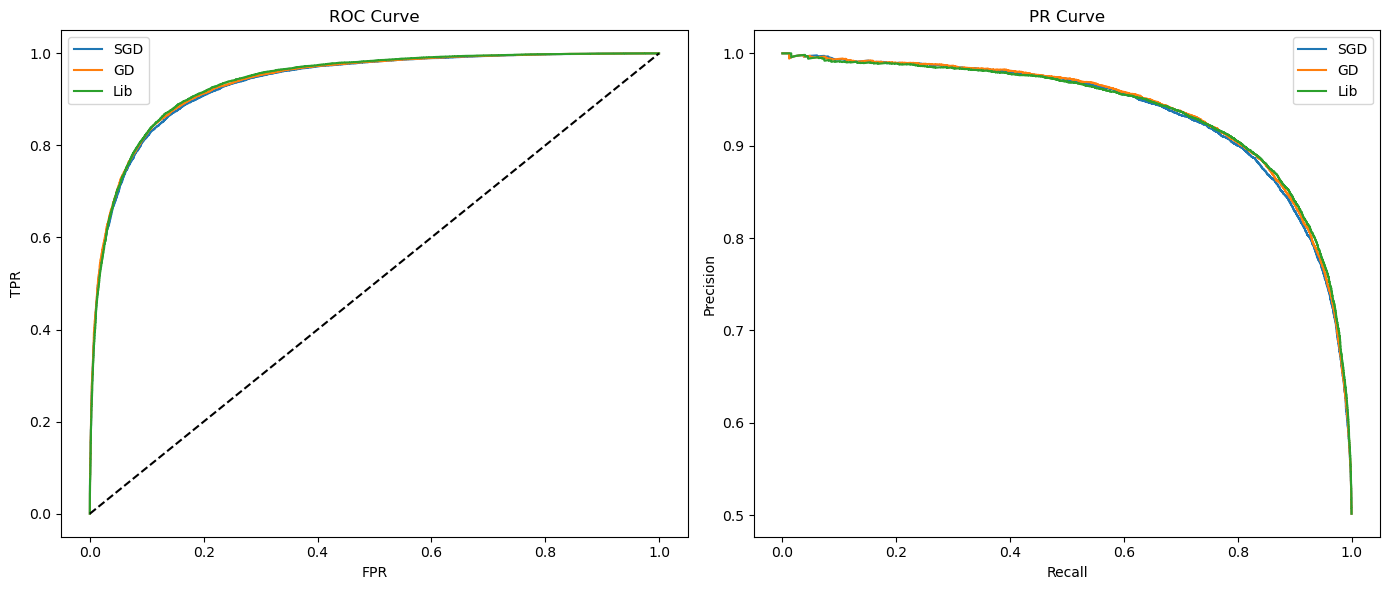

In [5]:
lr_lib = LogisticRegression(random_state=42)
lr_lib.fit(X_train, y_train)

models = [('SGD', lr_sgd), ('GD', lr_full), ('Lib', lr_lib)]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, model in models:
    if name == 'Lib':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))
    
    print(f"{name}: accuracy={acc:.3f}, ROC-AUC={roc_auc:.3f}")
    plt.plot(fpr, tpr, label=f'{name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()


plt.subplot(1, 2, 2)
for name, model in models:
    if name == 'Lib':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)
        
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend()

plt.tight_layout()
plt.show()

### Сравнение моделей
#### Какая модель показывает лучший результат? Почему?
В целом, на синтетических данных все модели показывают достойные результаты. Как и следовало ожидать, по метрикам `accuracy` и `ROC-AUC` модель с Full GD показала результат лучше, чем с SGD. Это вытекает из самого принципа работы алгоритма : в полном градиентном спуске вектор градиента рассчитывается как среднее по всей обучающей выборке, что позволяет очень точно определять направление антиградиента. В стохастическом GD вектор градиента рассчитывается от одного случайного объекта. Поэтому, точность SGD получается меньше, хотя данный алгоритм работает существенно быстрее. Модель из `sklearn` показала лучшие результаты, хотя и приктически идентичные полному GD. Это является следствием того, что библиотечная лог. регрессия использует для оптимизации более продвинутые алгоритмы `L-BFGS` и включает `L2-регуляризацию`.

#### Есть ли что-то в модели из коробки, что по умолчанию делает её не равной моей модели?
Да, изучив документацию, можно заметить несколько отличий междеу моей и библиотечной реализацией логистической регрессии. Первым отличием является то, что в библиотечную реализацию встроена `L2-регуляризация`. По умолчанию установлен параметр `penalty=l2`. В моей реализации регуляризация не предусмотрена. Вторым отличием является то, что в библиотечной логистической регрессии по умолчанию добавляется свободный член `fit_intercept=True`. В моей реализации он не предусмотрен. Третье отличие - методы оптимизации. Библиотечная версия логистической регрессии использует более продвинутые алгоритмы.

### **Задание 3 (0.4 балла)**

Для трех полученных моделей, визуализируйте прогнозы по данным на тестовой выборке. Для этого:
- получите прогнозы;
- сомжите данные, используя PCA. Не забудьте, что PCA полагает нулевое среднее и единичную дисперсию;
- покрасьте данные по прогнозам.

Как различаются графики для трёх моделей? И различаются ли?

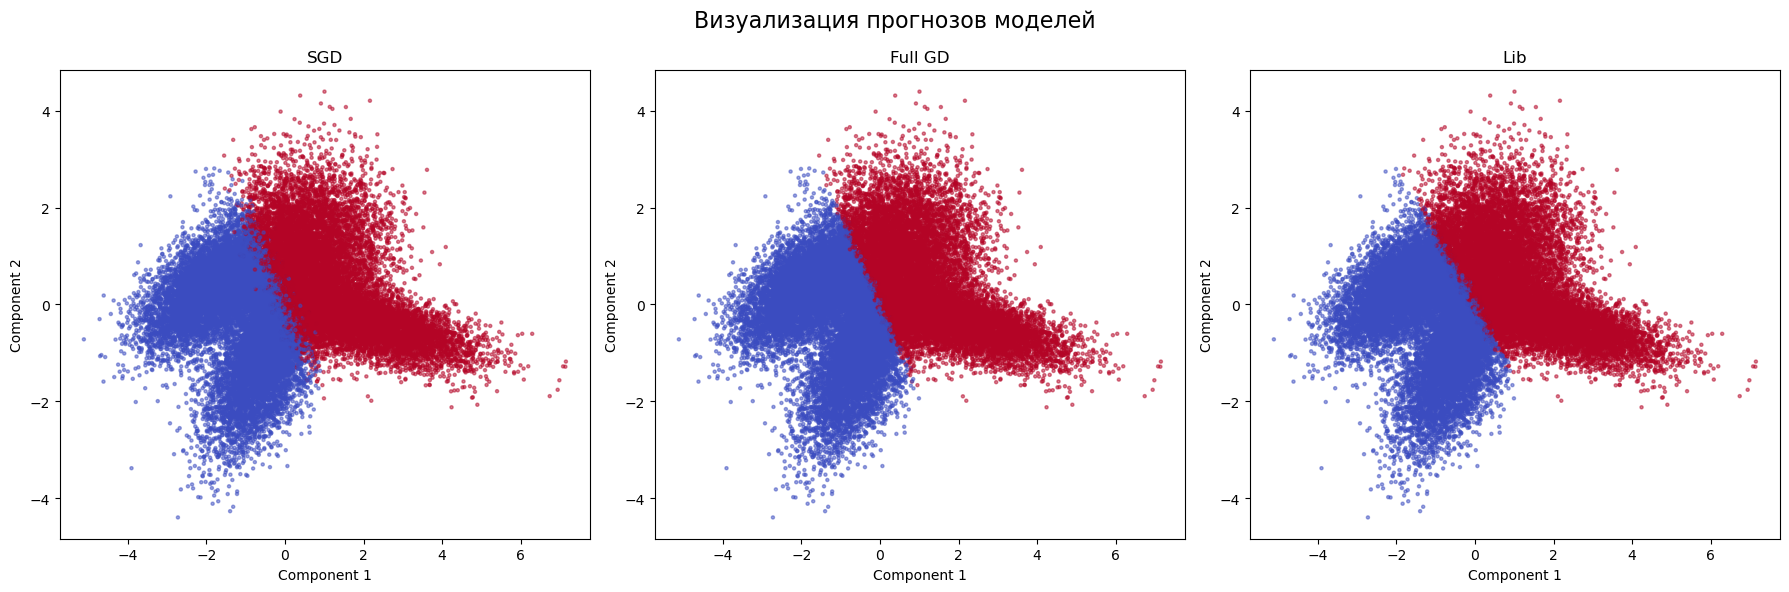

In [6]:
# получение прогнозов
pred_sgd = lr_sgd.predict(X_test)
pred_full = lr_full.predict(X_test)
pred_lib = lr_lib.predict(X_test)

# сжатие данных с помощью PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_test_pca = pca.transform(X_test)

# визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = [('SGD', pred_sgd), ('Full GD', pred_full), ('Lib', pred_lib)]

for ax, (name, preds) in zip(axes, models):
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=preds, cmap='coolwarm', s=5, alpha=0.5)
    ax.set_title(name)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

plt.suptitle('Визуализация прогнозов моделей', fontsize=16)
plt.tight_layout()
plt.show()

### Как различаются графики для трёх моделей?
А никак! Графики практически не различаются, разве что у SGD в районе гиперплоскости видим большее количество ошибок. Это подтверждает сделанные ранее выводы: практически идентичные результаты метрик говорили о том, что модели построили почти одинаковые гиперплоскости в 20-мерном пространстве. При проекции гиперплоскости на 2-мерное пространство, она также осталась похожей.

# **Часть 2. Обучение моделей на текстовых данных. (5 баллов)**

 ### **Подготовка данных из реального мира.**

Ещё одна прелесть простых моделей — возможность решать с ними неструктурированные (изначально не табличные) задачи. Давайте посмотрим на это в действии на примере текстов.


Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [7]:
from sklearn.model_selection import train_test_split

PATH = 'C:/Users/user/Downloads/train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (1.5 балла).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой (0.2 балла).

In [8]:
data.shape

(7613, 5)

In [9]:
display(data.isna().sum())
data = data.fillna('')

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

- Проанализируйте количество уникальных значений в столбцах, опустив `text`. Сделайте выводы. (0.5 балла)

In [10]:
data.drop('text', axis=1).nunique()

id          7613
keyword      222
location    3342
target         2
dtype: int64

In [11]:
data.sample(7)

,id,keyword,location,text,target
3668,5222,fatality,Boston Û¢ Cape Cod ?,Dying of Lyme disease: Case fatality rate near...,1
6521,9325,survive,? icon by @Hashiren_3 ?,@mochichiiiii @hikagezero IT'S IMPOSSIBLE FOR ...,0
3457,4945,exploded,zboyer@washingtontimes.com,Kai Forbath just demolished a weather station ...,1
608,877,bioterror,,FedEx no longer to transport bioterror germs i...,1
7303,10450,wild%20fires,"Dallas, TX",PRAYERS FOR MY COUSIN! He's in California help...,1
2151,3086,deaths,Blackpool,Cancers equate for around 25% of all deaths in...,1
5348,7634,pandemonium,,My workplace is going to be pandemonium when t...,0


#### Анализ уникальных значений
Количество уникальных значений `id` совпадает с количеством объектов в датасете. Данный признак не несёт важной информации, его использование приведет к переобучению, поэтому столбец `id` стоит удалить. Количество уникальных слов - 222 для 7613 объектов, что говорит об отличной плотности данных. Признак `keyword` является важным категориальным признаком. У признака `location`, учитывая 2533 пропуска, большинство значений являются уникальными. Значит, эти данные введены с сильным шумом, без какого-либо стандарта. Нужно проанализировать это признак и, если это возмозможно, обработать. Признак `target` содержит 2 уникальных значения, что говорит о том, что данная задача является задачей бинарной классификации.

- Проанализируйте соотношение классов в целевой переменной. Какое оно? Выберите метрику, с помощью которой будете оценивать модель.  (0.5 балла)

In [12]:
data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

#### Анализ соотношения классов в целевой переменной и выбор метрики
В данных преобладает класс со значением `0`, но сильного дисбаланса между ними нет. Поскольку классы сбалансированны, вполне может подойти метрика `accuracy`, но если проанализировать данную задачу, то можно прийти к выводу, что в конкретном случае будет полезно оценить `f1-score` по причине того, что задача состоит в определении постов, сообщающих о чрезвычайной ситуации и было бы полезно соблюдать баланс между `precision` и `recall`, чтобы и не пропустить сигнал о бедствии, и не создавать ложной паники.

- Объедините все три текстовых столбца в один для baseline (вам поможет конкатенация строк) (0.3 балла)

In [13]:
data_new = data.copy()
data_new['text'] = data['keyword'].astype(str) + ' ' + data['location'].astype(str) + ' ' + data['text'].astype(str)
data_new['text'] = data_new['text'].str.strip()

- Наконец, поделите данные на тренировочную и тестовую выборки. (0.2 балла)

In [14]:
X = data_new['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

display(X_train.shape)
display(X_test.shape)

(5329,)

(2284,)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества и насколько разнообразны данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица? (0.3 балла)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
bow = CountVectorizer()

X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

display(X_train_bow.shape)
display(X_test_bow.shape)

(5329, 18455)

(2284, 18455)

Матрица получилась очень большой. При этом из-за специфики `CountVectorizer`, она получилась разреженной. Если не удалить лишний мусор, модель может переобучиться

- Обучите логистическую регрессию на полученном наборе. Модель возьмите из библиотеки. Какое качество по выбранной вами метрике у модели получилось на тестовых данных? (0.3 балла)

In [17]:
from sklearn.metrics import f1_score, classification_report
import time

In [18]:
logreg = LogisticRegression(random_state=42)

start = time.time()
logreg.fit(X_train_bow, y_train)
fit_time = time.time() - start

y_pred_logreg = logreg.predict(X_test_bow)
f1_logreg = f1_score(y_test, y_pred_logreg)

print(f'Время обучения LR: {fit_time:.2f} сек.')
print(f'f1-score: {f1_logreg:.3f}')
print(classification_report(y_test, y_pred_logreg))

Время обучения LR: 0.13 сек.
f1-score: 0.753
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1318
           1       0.79      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



Качество по выбранной мной метрике получилось `f1-score=0.753`. Это весьма достойный результат, учитывая то, что не было предварительной существенной предобработки данных и чистки мусора. Это, вероятнее всего, говорит о том, что модель отлавливает ключевые слова, которые служат сильным тригером для выявления чрезвычайной ситуации, даже в такой ситуации. Если посмотреть на `classification report`, то видно, что `recall=0.72` заметно отстает от `precision`. Вероятно, это происходит из-за наличия шума, который мешает модели корректно определять чрезвычайные ситуации.

- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.(0.4 балла)

In [19]:
svm = SVC(random_state=42)

start = time.time()
svm.fit(X_train_bow, y_train)
fit_time = time.time() - start

y_pred_svm = svm.predict(X_test_bow)
f1_svm = f1_score(y_test, y_pred_svm)

print(f'Время обучения SVC: {fit_time:.2f} сек.')
print(f'f1-score: {f1_svm:.3f}')
print(classification_report(y_test, y_pred_svm))

Время обучения SVC: 3.38 сек.
f1-score: 0.743
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1318
           1       0.84      0.67      0.74       966

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.80      0.80      2284



По метрике `f1-score` метод опорных векторов отработал хуже (0.743 против 0.753 у логистической регрессии). По умолчанию `SVC` использует ядро `rbf`, которое строит нелинейные границы. В данной задаче это избыточно и приводит к более плохим результатам. Также, стоит обратить внимание на то, что `SVC` отработал во много раз медленнее, чем логистическая регрессия. Поэтому использование этого метода в данной задаче неоптимально.

### **Задание 12. Улучшение базовых моделей за счет данных. (0.3 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют.

Обучайте и логистическую регрессию, и SVC.

In [20]:
new_bow = CountVectorizer(min_df=8, max_features=1000)

X_train_nbow = new_bow.fit_transform(X_train)
X_test_nbow = new_bow.transform(X_test)

display(X_train_nbow.shape)
display(X_test_nbow.shape)

(5329, 1000)

(2284, 1000)

In [21]:
logreg = LogisticRegression(random_state=42)

start = time.time()
logreg.fit(X_train_nbow, y_train)
fit_time = time.time() - start

y_pred_logreg = logreg.predict(X_test_nbow)
f1_logreg = f1_score(y_test, y_pred_logreg)

print(f'Время обучения LR: {fit_time:.2f} сек.')
print(f'f1-score: {f1_logreg:.3f}')
print(classification_report(y_test, y_pred_logreg))


svm = SVC(random_state=42)

start = time.time()
svm.fit(X_train_nbow, y_train)
fit_time = time.time() - start

y_pred_svm = svm.predict(X_test_nbow)
f1_svm = f1_score(y_test, y_pred_svm)

print(f'\n\nВремя обучения SVC: {fit_time:.2f} сек.')
print(f'f1-score: {f1_svm:.3f}')
print(classification_report(y_test, y_pred_svm))

Время обучения LR: 0.04 сек.
f1-score: 0.738
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1318
           1       0.76      0.71      0.74       966

    accuracy                           0.79      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.78      0.79      0.78      2284



Время обучения SVC: 1.96 сек.
f1-score: 0.726
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1318
           1       0.81      0.66      0.73       966

    accuracy                           0.79      2284
   macro avg       0.79      0.77      0.78      2284
weighted avg       0.79      0.79      0.79      2284



При подборе гиперпараметров для `CountVectorizer` я использовал `min_df=8` и `max_features=1000`. `min_df` отвечает за минимальное количество постов, в которых встречается слово. То есть, таким образов были отсечены слова, которые использовались менее, чем в 8 постах. `max_features` отвечает за максимальное количество признаков после использования `CountVectorizer`. Также была попытка использовать `stop_words='english'`, но это не привело к увеличению значения метрики качества.

Таким образом, получилось значительно ускорить обучение модели, выполнив подбор гиперпараметров. Это доказывает, что большинство признаков были шумом.

### **Задание 13. Улучшение базовых моделей за счет данных 2. (0.7 балла).**

В первом пункте мы склеили все строки в одну. Но можно было бы поступить иначе — и получить категории из `'keyword', 'location'`. Протестируйте такой подход на обеих моделях и замерьте качество. Улучшает ли это результат?

In [22]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

In [23]:
X_final = data[['keyword', 'location', 'text']].copy()

X_train_f, X_test_f, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

# bow для признака 'text'
final_bow = CountVectorizer(min_df=8, max_features=1000)
X_train_text = final_bow.fit_transform(X_train_f['text'])
X_test_text = final_bow.transform(X_test_f['text'])

# кодировка категориальных столбцов
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train_f[['keyword', 'location']])
X_test_cat = ohe.transform(X_test_f[['keyword', 'location']])

# объединение текстового столбца и категориальных 
X_train_final = hstack([X_train_text, X_train_cat])
X_test_final = hstack([X_test_text, X_test_cat])

display(X_train_final.shape)
display(X_test_final.shape)

(5329, 3693)

(2284, 3693)

In [24]:
logreg = LogisticRegression(random_state=42)

start = time.time()
logreg.fit(X_train_final, y_train)
fit_time = time.time() - start

y_pred_logreg = logreg.predict(X_test_final)
f1_logreg = f1_score(y_test, y_pred_logreg)

print(f'Время обучения LR: {fit_time:.2f} сек.')
print(f'f1-score: {f1_logreg:.3f}')
print(classification_report(y_test, y_pred_logreg))


svm = SVC(random_state=42)

start = time.time()
svm.fit(X_train_final, y_train)
fit_time = time.time() - start

y_pred_svm = svm.predict(X_test_final)
f1_svm = f1_score(y_test, y_pred_svm)

print(f'\n\nВремя обучения SVC: {fit_time:.2f} сек.')
print(f'f1-score: {f1_svm:.3f}')
print(classification_report(y_test, y_pred_svm))

Время обучения LR: 0.07 сек.
f1-score: 0.740
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1318
           1       0.78      0.70      0.74       966

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



Время обучения SVC: 2.50 сек.
f1-score: 0.735
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1318
           1       0.84      0.65      0.73       966

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.81      0.80      0.80      2284



Да, выделение категориальных признаков действительо позволило улучшить результат(`f1-score` 0.74 против 0.738 прежде для логистической регрессии и 0.735 против 0.726 прежде). Признак `location`, как и говорилось ранее, очень шумный и разреженный. Сделав для него OHE, мы добавили более 2000 столбцов, в которых единиц очень мало. Поэтому, выделение категориальных признаков не оказало столь существенного эффекта, как могло бы оказать при предварительной обработке `location`.

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
params = {'C': np.arange(0.1, 1.6, 0.1), 'penalty': ['l1', 'l2']}

logreg = LogisticRegression(random_state=42, solver='liblinear')

gs = GridSearchCV(logreg, params, cv=5, scoring='f1')
gs.fit(X_train_final, y_train)

print(f"Лучшие параметры: {gs.best_params_}")
print(f"Лучший F1 на кросс-валидации: {gs.best_score_:.4f}")

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test_final)
test_f1 = f1_score(y_test, y_pred)

print(f"F1-score на тестовой выборке с лучшими параметрами: {test_f1:.4f}")

Лучшие параметры: {'C': np.float64(0.5), 'penalty': 'l2'}
Лучший F1 на кросс-валидации: 0.7409
F1-score на тестовой выборке с лучшими параметрами: 0.7488


Для логистической регрессии я побробовал подобрать оптимальные гипермараметры `C` и `penalty`. `C` отвечает за силу регуляризации - чем больше `C`, тем слабее модель штрафуетсяза большие веса. По умолчанию для логистической регрессии этот гиперпараметр равен 1, но перебор грид сёрчем показал, что оптимальное значение равно 0.5, что говорит о том, что в данном случае нужна более сильная регуляризация, чтобы опираться на надёжные признаки. Гиперпараметр `penalty` отвечает за сам тип применяемой регуляризации. По умолчанию лог. регрессия использует l2-регуляризацию, но я решил попробовать ещё и l1-регуляризацию, при этом используя `solver='liblinear'`, так как остальные солверы не поддерживают и l1, и l2 регуляризацию. В результате оказалось, что l2-регуляризация оказалась оптимальна. Это может говорить о том, что после ограничения количества признаков с помощью `max_features=1000` в `CountVectorizer` практически не осталось признаков, которые надо занулять.

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [27]:
params = {'C': np.linspace(0.05, 1, 20), 'kernel': ['linear', 'rbf'], 'class_weight': [None, 'balanced']}

svm = SVC(random_state=42)

gs_svc = GridSearchCV(svm, params, cv=5, scoring='f1', n_jobs=-1)
gs_svc.fit(X_train_final, y_train) 

print(f"Лучшие параметры: {gs_svc.best_params_}")
print(f"Лучший F1 на кросс-валидации: {gs_svc.best_score_:.4f}")

best_svc = gs_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test_final)
test_f1_svc = f1_score(y_test, y_pred_svc)

print(f"F1-score на тестовой выборке с лучшими параметрами: {test_f1_svc:.4f}")

Лучшие параметры: {'C': np.float64(0.1), 'class_weight': 'balanced', 'kernel': 'linear'}
Лучший F1 на кросс-валидации: 0.7449
F1-score на тестовой выборке с лучшими параметрами: 0.7472


Для метода опорных векторов я попробовал подобрать следующие оптимальные параметры: `C`, `kernel` и `class_weight`. `C` отвечает за силу регуляризации - чем больше `C`, тем сильнее модель штрафует ошибки. По умолчанию равен 1. В данном случае грид серч подобрал значение `C` равное 0.1.
Гиперпараметр `kernel` отвечает за тип используемого ядра. По умолчанию `SVC` использует ядро `rbf`, которое пытается найти нелинейную разделяющую поверхность. В данном случае ядро `linear`, которое ищет линейную разделяющую поверхность, показало результаты лучше, поскольку в многомерных пространствах данные часто становятся линейно разделимыми. Также я протестировал перебор гиперпараметра `class_weight`, так как в данных есть небольшой перекос в сторону 0. Это действительно помогло и оптимальным оказался `class_weight='balanced'`. По итогу, с подобранными гиперпараметрами `SVC` показал практически идентичные логистической регрессии результаты.

### **Задание 14. (0.5 балла)**

Оформите два [пайплайна](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# предобработка данных
def fill_nans(df):
    return df.fillna('').astype(str)

# выделяем категориальные данные отдельно от текста
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(min_df=8, max_features=1000), 'text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['keyword', 'location'])
    ]
)

# пайплайн для логистической регрессии
pipe_lr = Pipeline([
    ('filler', FunctionTransformer(fill_nans)),
    ('union', preprocessor),
    ('model', LogisticRegression(random_state=42, C=0.5, solver='liblinear', penalty='l2'))
])

# пайплайн для метода опорных векторов
pipe_svc = Pipeline([
    ('filler', FunctionTransformer(fill_nans)),
    ('union', preprocessor),
    ('model', SVC(random_state=42, kernel='linear', C=0.1, class_weight='balanced'))
])


pipe_lr.fit(X_train_f, y_train)
pred_lr = pipe_lr.predict(X_test_f)
print(f"F1-score для логистической регрессии: {f1_score(y_test, pred_lr):.4f}")

pipe_svc.fit(X_train_f, y_train)
pred_svc = pipe_svc.predict(X_test_f)
print(f"F1-score для SVC: {f1_score(y_test, pred_svc):.4f}")

F1-score для логистической регрессии: 0.7488
F1-score для SVC: 0.7472


**Опишите общие мысли о работе. Это место для вашей рефлексии, не обязательное, но полезное.**  🐤

Для меня, как для относительно начинающего и невероятно мотивированного специалиста в области машинного обучения, было крайне полезно выполнить данное домашнее задание: пройдя через этапы самостоятельного написания кастомной модели логистической регрессии, применения PCA, сравнения различных подходов работы с текстом и т.д., получилось отлично закрепить материал и применить теоретические знания на практике. Отлично позволяют закрепиться материалу в голове выводы, которые необходимо привести практически после каждого пункта. Это позволяет еще раз осмыслить проделанное и лишний раз проверить себя, сравнив то, что ожидается теоретически и то, что получается по факту. Я, что благодаря этой домашке я 'добил' тему логистической регрессии и метода опорных векторов на бинарных данных и готов двигаться дальше.